# Deep Learning Group Project

### Sabrina Sok, Divya Shankar, Snigdha Jain

In [62]:
import shutil, os
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
import random

## Import and Process Data

In [69]:
rootDir = '/Users/sabrinasok/'
rawDataDir = rootDir + 'Desktop/MURA-v1.1/'
rawTrainDir = rawDataDir + 'train/'
rawValDir = rawDataDir + 'valid/'
label_dict = {'positive':1, 'negative':0}
trainP = np.array([rootDir + 'Desktop/' + x for x in np.loadtxt(
            rawDataDir + 'train_image_paths.csv', dtype = str)])
trainLab = np.array([label_dict[x.split('/')[-2].split('_')[-1]] for x in trainP])
valP = np.array([rootDir + 'Desktop/' + x for x in np.loadtxt(
            rawDataDir + 'valid_image_paths.csv', dtype = str)])
valLab = np.array([label_dict[x.split('/')[-2].split('_')[-1]] for x in valP])

processedDataDir = rootDir + 'Desktop/Processed_MURA/'
processedTrainDir = processedDataDir + 'Train/'
processedValidDir = processedDataDir + 'Valid/'

checkpoint_dir = rootDir + 'Desktop/Weights/'

In [3]:
trainP[:3]

array(['/Users/sabrinasok/Desktop/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png',
       '/Users/sabrinasok/Desktop/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png',
       '/Users/sabrinasok/Desktop/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png'],
      dtype='<U94')

In [4]:
def make_data(files, destination, labels=['positive', 'negative']):
    new_names = []
    path_exist = os.path.isdir(destination)
    os.makedirs(destination, exist_ok = True)
    if path_exist:
        print('Not copying new files over as the directories already exist!')
    for l in labels:
        os.makedirs(os.path.join(destination, l), exist_ok = True)
    for i, f in enumerate(files):
        label = f.split('/')[-2].split('_')[-1]
        new_path = os.path.join(destination, label) + '/' + str(i) + '.png'
        new_names.append(new_path)
        if path_exist is False:
            shutil.copyfile(f, new_path)
    print('Finished!')
    return new_names

In [5]:
train_path = make_data(trainP, destination=processedTrainDir)

Not copying new files over as the directories already exist!
Finished!


In [6]:
val_path = make_data(valP, destination=processedValidDir)

Not copying new files over as the directories already exist!
Finished!


In [139]:
np.shape(train_path)

(36808,)

## Visualize Amount of Data

In [7]:
trainP

array(['/Users/sabrinasok/Desktop/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png',
       '/Users/sabrinasok/Desktop/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png',
       '/Users/sabrinasok/Desktop/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png',
       ...,
       '/Users/sabrinasok/Desktop/MURA-v1.1/train/XR_HAND/patient11184/study1_negative/image1.png',
       '/Users/sabrinasok/Desktop/MURA-v1.1/train/XR_HAND/patient11184/study1_negative/image2.png',
       '/Users/sabrinasok/Desktop/MURA-v1.1/train/XR_HAND/patient11184/study1_negative/image3.png'],
      dtype='<U94')

In [8]:
trainLab

array([1, 1, 1, ..., 0, 0, 0])

In [9]:
def count_sample_representation(trainP, valP, trainLab, valLab):
    train_n = len(trainP)
    train_positive = sum(trainLab)
    train_positive_p = train_positive / train_n
    train_negative = train_n - train_positive
    train_negative_p = train_negative / train_n
    
    val_n = len(valP)
    val_positive = sum(valLab)
    val_positive_p = val_positive / val_n
    val_negative = val_n - val_positive
    val_negative_p = val_negative / val_n
    
    fig, ax = plt.subplots(figsize = (4, 3), dpi=120)
    ax.bar([0, 1, 2, 3],
          [train_negative, train_positive, val_negative, val_positive],
          width = 0.85, zorder = 10, color = ['C0', 'C0', 'C1', 'C1'],
          alpha = 0.8, edgecolor = 'k')
    ax.set_xticklabels([' ', 'Negative', 'Positive', 'Negative', 'Positive'],
            fontsize = 8)
    ax.set_ylabel('Number of samples')
    ax.text(0.25, -0.175, 'Train', ha = 'center', transform = ax.transAxes)
    ax.text(0.75, -0.175, 'Validation', ha = 'center', transform = ax.transAxes)
    ax.text(0, train_negative/1.2, str(round(train_negative_p, 2)*100) + '%',
            ha = 'center', zorder = 10, weight = 'bold', fontsize = 10)
    ax.text(1, train_positive/1.2, str(round(train_positive_p, 2)*100) + '%',
            ha = 'center', zorder = 10, weight = 'bold', fontsize = 10)
    ax.text(2, val_negative*1.5, str(round(val_negative_p, 2)*100) + '%',
            ha = 'center', zorder = 10, weight = 'bold', fontsize = 10)
    ax.text(3, val_positive*1.5, str(round(val_positive_p, 2)*100) + '%',
            ha = 'center', zorder = 10, weight = 'bold', fontsize = 10)

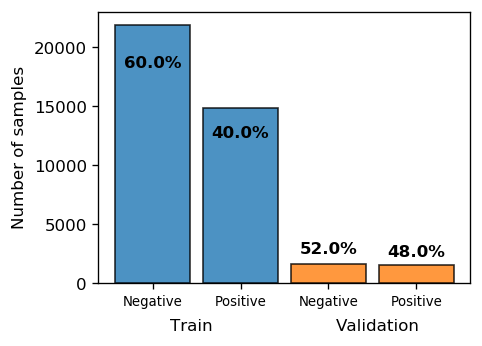

In [10]:
count_sample_representation(trainP, valP, trainLab, valLab)

In [11]:
def count_key(ls, key=-4, sep='/'):
    return([x.split(sep)[key] for x in ls])

In [12]:
def organ_type_label_frequency(trainP, valP, trainLab, valLab):
    train_n = len(trainP)
    val_n = len(valP)
    train_org = np.unique(count_key(trainP), return_counts = True)
#     return train_org
    val_org = np.unique(count_key(valP), return_counts = True)
    total_x = np.unique(np.concatenate([train_org[0], val_org[0]]))
    fig, axs = plt.subplots(figsize = (6, 4), dpi = 120, nrows = 2)
    fig.subplots_adjust(hspace = 0.4)
    for ax in axs: ax.tick_params(labelsize = 6)
    for i, u in enumerate(total_x):
        sub1 = (train_org[0] == u)
        sub2 = (val_org[0] == u)
        axs[0].bar(total_x[i], train_org[1][sub1], color = 'C0', ec = 'k', zorder = 10, width = 0.5)
        axs[1].bar(total_x[i], val_org[1][sub2], color = 'C1', ec = 'k', zorder = 10, width = 0.5)
    axs[0].set_ylabel('Counts')
    axs[0].set_title('Train')
    axs[1].set_ylabel('Counts')
    axs[1].set_title('Validation')
    axs[1].set_xlabel('Organ')

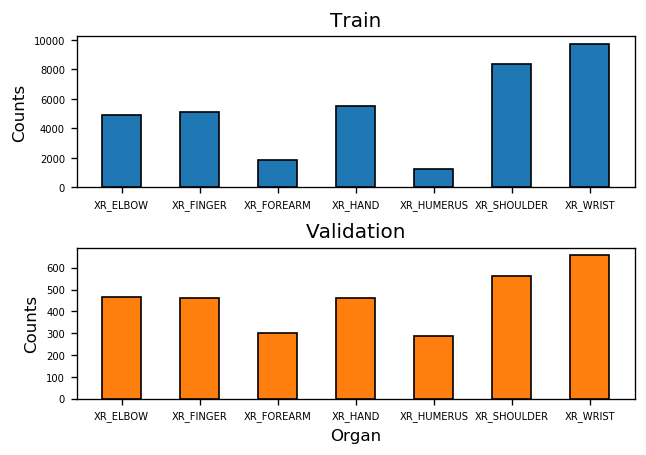

In [13]:
organ_type_label_frequency(trainP, valP, trainLab, valLab)

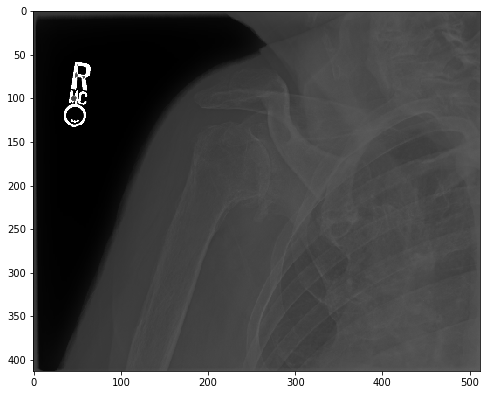

In [14]:
import cv2
img = cv2.imread(trainP[3])
plt.figure(figsize = (8,8))
plt.imshow(img)
plt.show()

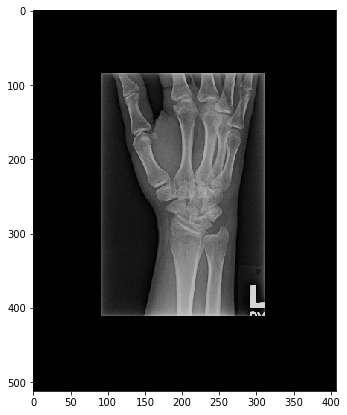

In [15]:
img = cv2.imread(valP[500])
plt.figure(figsize = (7,7))
plt.imshow(img)
plt.show()

## Transfer Learning with MobileNet

In [79]:
from keras.applications import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import optimizers
from keras import models
from keras import layers
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

In [17]:
conv_base = MobileNetV2(weights = 'imagenet',
                     include_top = False)

In [18]:
conv_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
_______________________________________________________________________________

In [19]:
datagen = ImageDataGenerator(rescale = 1./255)

In [20]:
batch_size = 20

In [21]:
def extract_features (directory, sample_count):
    features = np.zeros(shape = (sample_count,7,7,1280))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                           target_size = (224, 224),
                                           batch_size = batch_size,
                                           class_mode = 'binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i* batch_size: (i+1) * batch_size] = features_batch
        labels[i * batch_size: (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
        return features, labels

In [23]:
train_features, train_labels = extract_features(processedTrainDir, 5000)
validation_features, validation_labels = extract_features(processedValidDir, 1000)

Found 36808 images belonging to 2 classes.
Found 3197 images belonging to 2 classes.


In [26]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(7,7,1280)))
model.add(layers.Dense(256, activation='relu', input_dim=(7*7*1280)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16056576  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,056,833
Trainable params: 16,056,833
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

## Test 2

In [104]:
learning_rate = 0.1
decay_rate = 0.1

In [135]:
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation = 'relu', input_shape = (300, 300, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64,(3,3),activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64,(3,3),activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128,(3,3),activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128,(3,3),activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(256,(3,3),activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256,(3,3),activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(512,(3,3),activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512,(3,3),activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(512,(3,3),activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512,(3,3),activation = 'relu'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(512,(3,3),activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256,(3,3),activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128,(3,3),activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64,(3,3),activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32,(3,3),activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(16,(3,3),activation = 'relu'))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

ValueError: Negative dimension size caused by subtracting 3 from 1 for 'conv2d_180/convolution' (op: 'Conv2D') with input shapes: [?,1,1,512], [3,3,512,512].

In [94]:
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['acc'])

In [95]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(processedTrainDir,
                                                   target_size = (224, 224),
                                                   batch_size = 15,
                                                   class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(processedValidDir,
                                                       target_size = (224, 224),
                                                       batch_size = 15,
                                                       class_mode = 'binary')

Found 36808 images belonging to 2 classes.
Found 3197 images belonging to 2 classes.


In [140]:
def make_callbacks(checkpoint_dir, metric = 'accuracy'):
    callbacks = [
        ModelCheckpoint(filepath=checkpoint_dir + '/gpu_weights_' + str(random.randint(0,30)) + '.hdf5',
                       monitor = 'loss', save_best_only = False, verbose = 1),
        ReduceLROnPlateau(monitor = metric, factor = 0.5, patience = 20, verbose = 1)]
    callbacks.append(CSVLogger(checkpoint_dir + 'gpu_stats_per_epoch_' + str(random.randint(0,30)) + '.csv', 
                               append = True))
    return callbacks

In [105]:
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate

In [141]:
save_checkpoint = make_callbacks(checkpoint_dir+'complex_model/', 'accuracy')

In [113]:
loss_history = History()
checkpoint = ModelCheckpoint(filepath=checkpoint_dir,save_weights_only=True,verbose=1)
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [loss_history, lr_rate, checkpoint]

In [114]:
history = model.fit_generator(train_generator,
                             steps_per_epoch = 100,
                             epochs = 10,
                             validation_data = validation_generator,
                             callbacks = callbacks_list,
                             validation_steps = 50)

Epoch 1/10
 85/100 [========================>.....] - ETA: 32s - loss: 2.6358 - acc: 0.5192

KeyboardInterrupt: 

In [28]:
history = model.fit(train_features,
                    train_labels,
                    epochs = 10,
                    batch_size = batch_size,
                    validation_data = (validation_features, validation_labels))

Train on 5000 samples, validate on 1000 samples
Epoch 1/10
 700/5000 [===>..........................] - ETA: 30s - loss: 0.7938 - acc: 0.9986

KeyboardInterrupt: 

In [13]:
history = model.fit_generator(train_generator,
                             steps_per_epoch = 100,
                             epochs = 6,
                             validation_data = validation_generator,
                             validation_steps = 50)

Epoch 1/6
100/100 [==============================] - 87s 870ms/step - loss: 0.8520 - acc: 0.6975 - val_loss: 1.2403 - val_acc: 0.5756
Epoch 2/6
100/100 [==============================] - 77s 768ms/step - loss: 0.7986 - acc: 0.7113 - val_loss: 1.2325 - val_acc: 0.6055
Epoch 3/6
100/100 [==============================] - 81s 814ms/step - loss: 0.8049 - acc: 0.7175 - val_loss: 1.2161 - val_acc: 0.6106
Epoch 4/6
100/100 [==============================] - 74s 744ms/step - loss: 0.7452 - acc: 0.7300 - val_loss: 0.9539 - val_acc: 0.6324
Epoch 5/6
100/100 [==============================] - 77s 769ms/step - loss: 0.7503 - acc: 0.7328 - val_loss: 1.2652 - val_acc: 0.6256
Epoch 6/6
100/100 [==============================] - 73s 733ms/step - loss: 0.7304 - acc: 0.7434 - val_loss: 0.7568 - val_acc: 0.6556


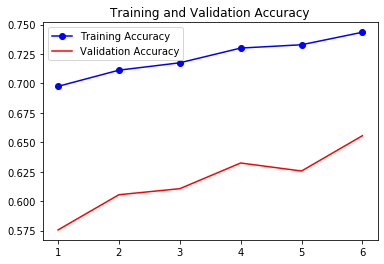

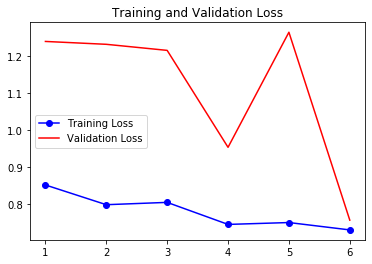

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## stop

In [6]:
model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics = ['acc'])

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (150, 150),
                                                   batch_size = 32,
                                                   class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                       target_size = (150, 150),
                                                       batch_size = 32,
                                                       class_mode = 'categorical')

Found 36808 images belonging to 7 classes.
Found 3197 images belonging to 7 classes.


In [1]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.
